# Project Report: Predicting User Knowledge from Prerequisite Exam Performance and Goal Exam Performance

**DSCI 100 009: Group 23** <br>
Allison Fellhauer (38395166) <br>
Agastya Kaul (78851433) <br>
Grace Li (27986504) <br>
Xiangyuan Li (57380230) <br>

## 1. Introduction: Data set and background information

### 1.1 Background Information

#### 1.1.1 User Modeling and User Knowledge

User modeling is used to create a representation of a user based on their interactions with the system ([Chignell & Hancock, 1988](https://doi.org/10.1016/B978-0-444-70536-5.50051-8)). This model can be used to personalize and improve a user’s experience  ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). For example, in e-learning, a user model can be used to track a student’s knowledge level to adapt their learning experience ([Al-Tarabily et al. 2018](https://doi.org/10.1109/ACCESS.2018.2847334)) .

In the dataset [User Knowledge Modeling](https://doi.org/10.24432/C5231X), the authors investigate which user interactions should be used to create the best user knowledge model ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). The goal is to dynamically adjust the student’s learning experience by building a model that classifies their knowledge-level ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

### 1.2 About the data set

**Our data set:** [User Knowledge Modeling](https://doi.org/10.24432/C5231X)

We have chosen to explore the User Knowledge Modeling data set, which is a data set that classifies users' knowledge of a topic (electrical DC machines) ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

There are 258 observations and 6 variables (5 features and 1 target) in the data set.

#### 1.2.1 Features (the predictors)
The features are elements of the user model that include two topics:

A) Goal topics (learning objects):
- The degree of time spent studying the material [STG, double]
- The degree of repetition of the material [SCG, double]
- The performance on exam [PEG, double]


B) Prerequisite topics:
- The degree of study time corresponding to the prerequisite objects [STR, double]
- The performance on prerequisite exams [LPR, double]

#### 1.2.2 Target (predicted class)
User knowledge level [UNS, factor]

Categorized into 4 levels:
- very low (beginner)
- low (intermediate)
- middle (expert) 
- high (advanced)

### 1.3 Our Question

**Can we predict the knowledge level of a user given their performance on prerequisite exams and their performance on the goal exam?**

## 2. Methods

### 2.1 Load necessary libraries and reading in the data

We began our project by loading in the necessary libraries.

In [1]:
#load all the necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("RColorBrewer")
library(RColorBrewer)
install.packages("kknn") 
library("kknn")
install.packages("themis")
library(themis)
install.packages("cowplot")
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

We then read the data from a URL.

In [2]:
#read data from the web (GitHub raw file)
url <- "https://raw.githubusercontent.com/afellhauer/DSCI_Group_Project/main/data/Data_User_Modeling_Dataset_Hamdi.csv"
knowledge <- read_csv(url)
head(knowledge)

Rows: 258 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


**Table 1**: First 6 rows of the user knowledge data set

### 2.2 Make data usable and readable

Looking at the values, the format is tidy. To make the data usable, UNS (user_knowledge) was converted from a character to a factor. To increase readability, we renamed all variables. We [checked for any missing data](https://www.tutorialspoint.com/dealing-with-missing-data-in-r) and [printed the result](https://www.geeksforgeeks.org/printing-output-of-an-r-program/). There are no missing values.

In [3]:
knowledge_mutate <- knowledge |>
    mutate(UNS = as_factor(UNS)) |> #change the class from a chr to a factor
    rename("study_time_goal" = STG, #relabel all variables to understand them better
           "repetition" = SCG,
           "study_time_related" = STR,
           "performance_related" = LPR, 
           "performance_goal" = PEG,
           "user_knowledge" = UNS) 

head(knowledge_mutate)

study_time_goal,repetition,study_time_related,performance_related,performance_goal,user_knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


**Table 2**: First 6 rows of the user knowledge data set with the column names renamed.

In [4]:
missing <- sum(is.na(knowledge_mutate)) # check for missing values
print(paste("Number of missing values: ", missing))

[1] "Number of missing values:  0"


### 2.3 Split the data into training and testing sets

To ensure reproducibility, we set the seed. We used a proportion of 0.75/0.25 for the training to testing ratio. We also stratified the data using user_knowledge, which is the class we are trying to predict. 

In [5]:
set.seed(200) #set seed to be reproducible
#create the initial split of the data
#stratify based on user_knowledge
knowledge_split <- initial_split(knowledge_mutate, prop = 0.75, strata = user_knowledge)

#collected the testing and training portions
knowledge_training <- training(knowledge_split)
knowledge_testing <- testing(knowledge_split)

glimpse(knowledge_training) #see that the number of rows is less than the dataset

Rows: 192
Columns: 6
$ study_time_goal     <dbl> 0.080, 0.180, 0.100, 0.090, 0.080, 0.200, 0.130, 0…
$ repetition          <dbl> 0.080, 0.180, 0.100, 0.300, 0.325, 0.450, 0.390, 0…
$ study_time_related  <dbl> 0.100, 0.550, 0.700, 0.680, 0.620, 0.280, 0.850, 0…
$ performance_related <dbl> 0.24, 0.30, 0.15, 0.18, 0.94, 0.31, 0.38, 0.71, 0.…
$ performance_goal    <dbl> 0.90, 0.81, 0.90, 0.85, 0.56, 0.78, 0.77, 0.90, 0.…
$ user_knowledge      <fct> High, High, High, High, High, High, High, High, Hi…


### 2.4 Summarize the data

We examined how balanced or unbalanced the data set is. We created a table that summarized the number of counts for each group of the user_knowledge variable (Table 3). 

The very_low (beginner) knowledge level is not as represented in this data set.

In [6]:
summary_counts <- knowledge_training |>
    group_by(user_knowledge) |> #group based on the class
    summarize(count = n()) #gets the count (number of observations of each)
summary_counts

user_knowledge,count
<fct>,<int>
very_low,20
High,47
Low,59
Middle,66


**Table 3**: Proportion of observations classified as each user knowledge level (very_low, low, high, middle)

We then summarized the means of all predictors for each class (Table 4).

In [7]:
summary <- knowledge_training |>
    select(user_knowledge, study_time_goal, repetition, performance_goal, performance_related, study_time_related) |> 
    #select only the class and the predictors
    group_by(user_knowledge) |>
    summarize("mean_study_time_goal" = mean(study_time_goal), "mean_repetition_goal" = mean(repetition),
              "mean_performance_goal" = mean(performance_goal), "mean_study_time_related" = mean(study_time_related), 
              "mean_performance_related" = mean(performance_related))
    #get the mean for each predictor for each group
summary

user_knowledge,mean_study_time_goal,mean_repetition_goal,mean_performance_goal,mean_study_time_related,mean_performance_related
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
very_low,0.3172000,0.1787500,0.0985000,0.3595000,0.3565000
High,0.4220000,0.4170426,0.7646809,0.5056383,0.5370213
Low,0.3249831,0.3482542,0.2386949,0.3989831,0.5015254
Middle,0.4147727,0.3676061,0.5430303,0.4892424,0.3301515


**Table 4**: Mean values for predictors of goal material (study time, repetition, performance) and related material (study time and performance) for each user knowledge level (very_low, low, middle, high).

### 2.5 Visualize the data

We visualized the distribution of the different groups according to their counts. Again, this highlights that the data is not completely balanced.

*To left align the caption, we used [this code](https://stackoverflow.com/questions/64701500/left-align-ggplot-caption)*.

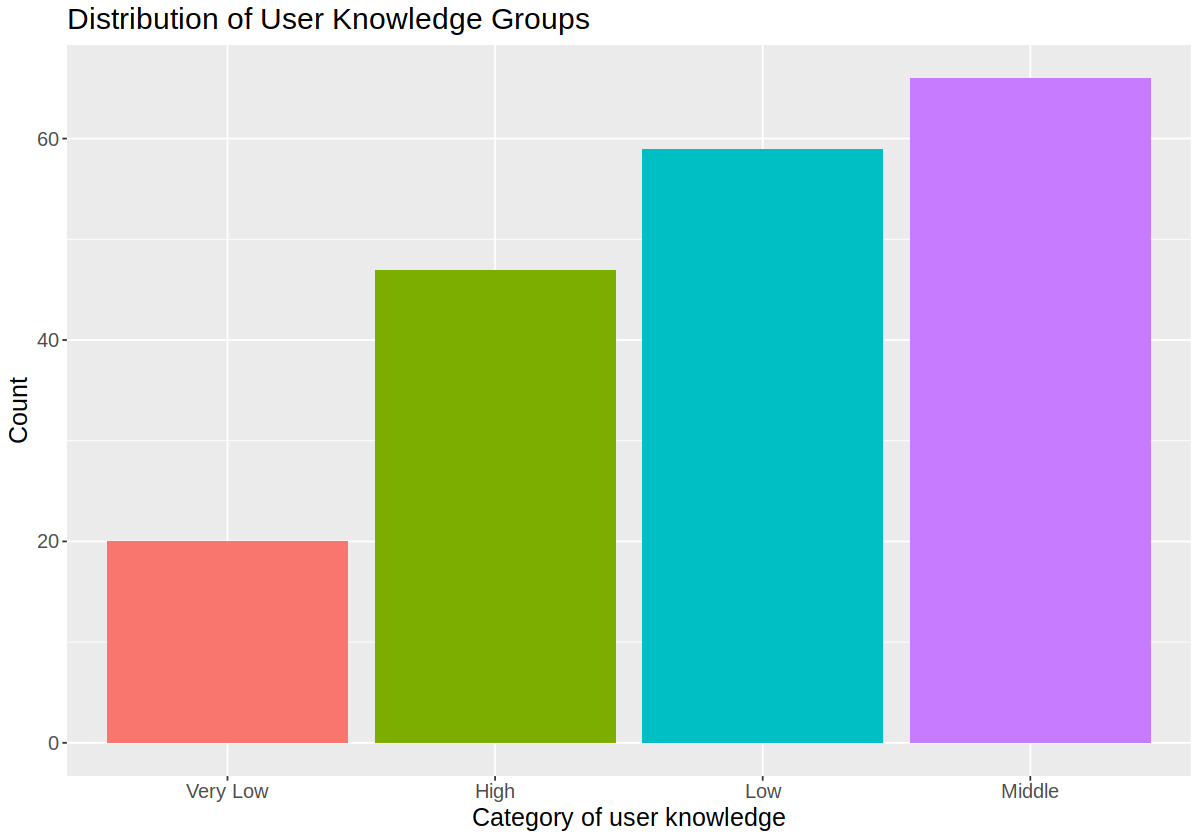

In [8]:
options(repr.plot.width = 10, repr.plot.height = 7)
knowledge_training_plot_distribution <- knowledge_training |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) + #change the label of very_low to Very Low
    geom_bar() + #use the default stat = "count"
    xlab("Category of user knowledge") +
    ylab("Count")

#make the plot look nicer
knowledge_training_plot_distribution <- knowledge_training_plot_distribution +
    theme(text = element_text(size = 15), legend.position = "none", #remove the legend
         plot.caption = element_text(hjust = 0)) + #set the text to left align
    ggtitle("Distribution of User Knowledge Groups") +
    scale_color_brewer(palette = "Set2") #set the color palette
    
knowledge_training_plot_distribution

**Figure 1:** Number of observations for each user knowledge group. Very low represents beginners, low represents 
intermediate, middle represents expert, and high represents advanced user knowledge"

### 2.6 Choose our predictors
To determine which predictors to use for our analysis, we used scatter plots to visualize the clustering of user knowledge. We created four scatter plots to visualize performance on exam on learning objects vs. each predictor. We considered that performance on the exam of the goal topic (performance_goal) is relevant to user knowledge. Therefore, we kept performance_goal fixed on the y-axis. We then plotted all other predictors (study_time_goal, study_time_related, repetition, performance_related) on the x-axis to look for relationships.

In [9]:
# Plot a) 
knowledge_training_plot_pre_req_study_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("a) Goal Object Performance vs Pre-Requisite Study Time")

In [10]:
# Plot b)
knowledge_training_plot_repetition_vs_goal <- knowledge_training |>
    ggplot(aes(x = repetition, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of repetition on learning objects (goal)") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("b) Goal Object Performance vs Goal Repetition")

In [11]:
# Plot c)
knowledge_training_plot_study_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_goal, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study time on learning objects (goal)") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("c) Goal Object Performance vs Goal Object Study Time")

In [12]:
# Plot d)
knowledge_training_plot_pre_req_performance_vs_goal <- knowledge_training |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("d) Goal Object Performance vs Pre-Requisite Performance")

We then used plot_grid to visualize all the plots together to make side-by-side comparisons.

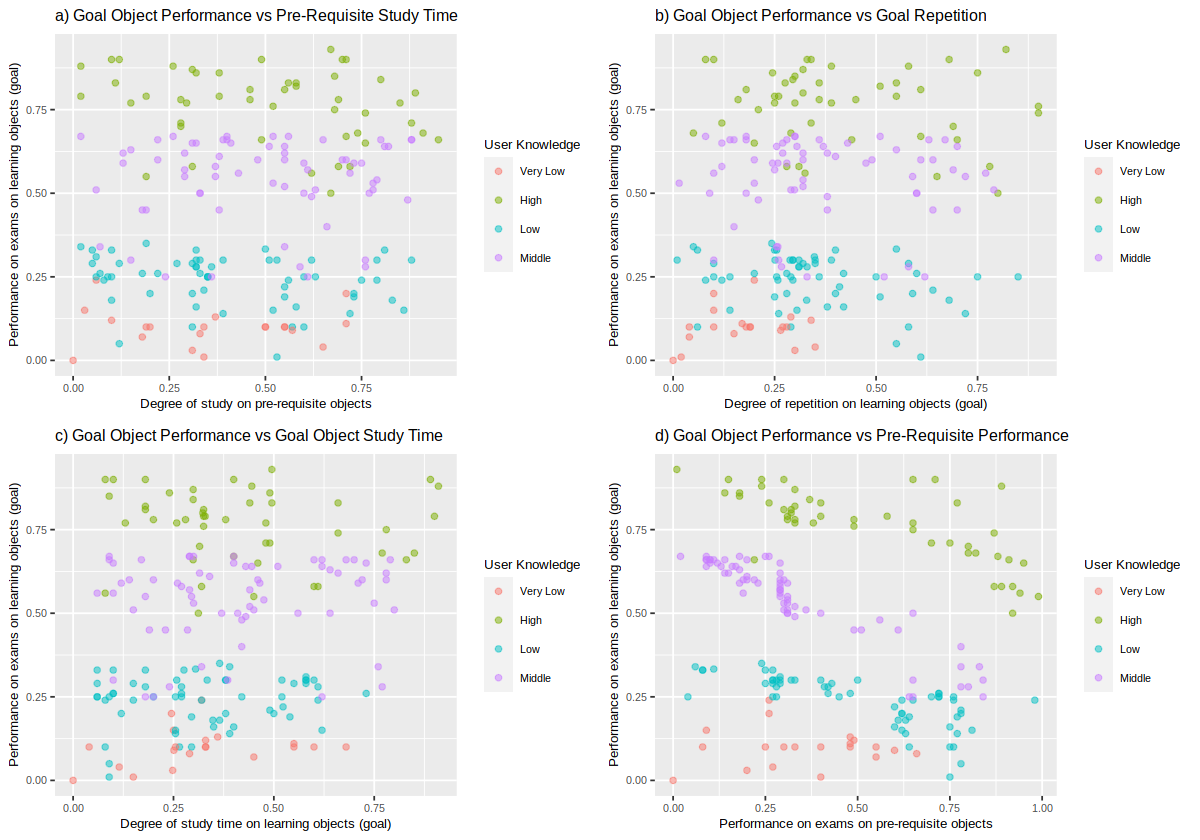

In [13]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot_grid(knowledge_training_plot_pre_req_study_vs_goal, knowledge_training_plot_repetition_vs_goal, knowledge_training_plot_study_vs_goal, 
          knowledge_training_plot_pre_req_performance_vs_goal, ncol = 2)

**Figure 2**: Grid plot of performance on exams of learning objects with four different predictor variables grouped by user knowledge category (very low, low, middle, high). The predictor variables are degree of study time on pre-requisite objects (a), degree of repetition on learning objects (b), degree of study on learning objects (c), and performance on exams of pre-requisite object (d).

Based on Figure 2, the most distinct clusters formed when plotting performance_related and performance_goal (d). Therefore, for our analysis, we will be using the following variables to be the predictors for user knowledge:
1. performance_related
2. performance_goal

Using performance as a predictor makes sense since student's knowledge of a topic is commonly evaluated using examinations. In addition, knowledge of pre-requisite topics is positively correlated with student achievement ([Hailikari et al., 2008](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2630138/)).

### 2.7 Our hypothesis

Our hypothesis is that the user's scores on both the prerequisite and goal exam can be used to predict their user knowledge level with high accuracy.

### 2.8 Analyse the data

As the data is unbalanced (see Fig. 1), we decide to create two models:
- Unbalanced model: the model where the training set is not upsampled
- Balanced model: the model where the training set is upsampled so all ratios are the same as the category with the greatest count (Middle)

We decided to balance our data because in KNN classification, class imbalance can heavily affect the accuracy of the system. If one label has more data points, its likelihood of being picked will increase, even if the patterns in the data show otherwise.

#### 2.8.1 Up-Sample the dataset

Our approach to balancing the data is to up-sample. We will accomplish this by creating a recipe with step_upsample applied to the user_knowledge variable and then applying "bake()" to produce a new up-sampled training data set. This new data set will be called knowledge_upsample. We summarized the information in a table to show the proportions are even and compare to the unbalanced data (Table 5).

In [14]:
set.seed(59) # set seed for reproducibility
# create a recipe to up-sample the current data set using step_upsample()
knowledge_recipe_up <- recipe(user_knowledge ~ performance_related + performance_goal, data = knowledge_training) |>
    step_upsample(user_knowledge, over_ratio = 1, skip = FALSE)

# prep the recipe
knowledge_prep_up <- knowledge_recipe_up |> prep() 

# bake the recipe to apply the changes to the data set
knowledge_upsampled <- bake(knowledge_prep_up, knowledge_training)

# summarize proportion
upsample_size <- knowledge_upsampled |> nrow()
upsampled_props <- knowledge_upsampled |>
    group_by(user_knowledge) |>
    summarize(distribution_upsampling = n() / upsample_size,
             count_upsampling = n())
# create a table with both the balanced and unbalanced data
knowledge_size <- knowledge_training |> nrow()
knowledge_props <- knowledge_training |>
    group_by(user_knowledge) |>
    summarize(distribution_no_upsampling = n() / knowledge_size, 
             count_no_upsampling = n()) |>
    merge(upsampled_props)
knowledge_props

user_knowledge,distribution_no_upsampling,count_no_upsampling,distribution_upsampling,count_upsampling
<fct>,<dbl>,<int>,<dbl>,<int>
High,0.2447917,47,0.25,66
Low,0.3072917,59,0.25,66
Middle,0.3437500,66,0.25,66
very_low,0.1041667,20,0.25,66


**Table 5**: Summary of the non-upsampled and up-sampled data set demonstrating the even ratios.

We then plot the distribution to see if the counts are all the same for Very Low, Low, Medium, and High. Figure 3 shows that the data is now balanced.

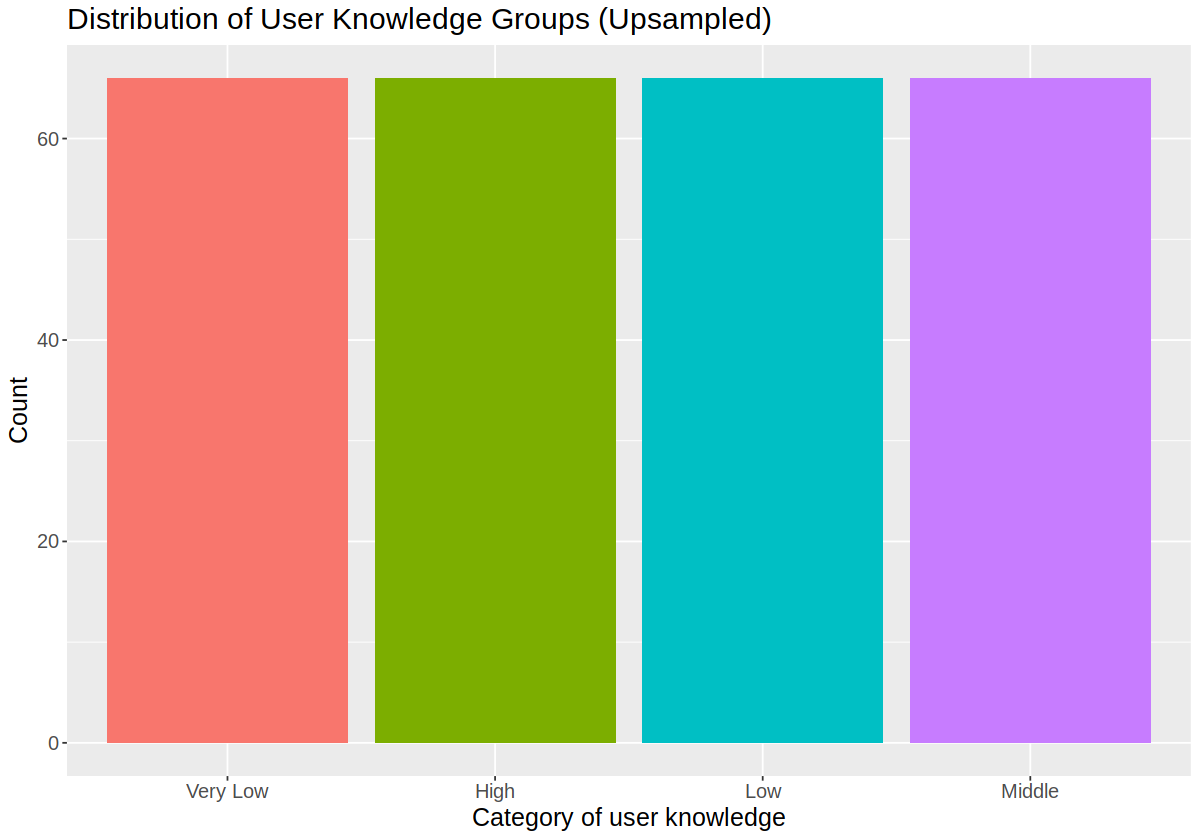

In [15]:

knowledge_training_plot_distribution_up <- knowledge_upsampled |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) + #change the label of very_low to Very Low
    geom_bar() + #use the default stat = "count"
    xlab("Category of user knowledge") +
    ylab("Count")

#make the plot look nicer
knowledge_training_plot_distribution_up <- knowledge_training_plot_distribution_up +
    theme(text = element_text(size = 15), legend.position = "none", #remove the legend
         plot.caption = element_text(hjust = 0)) + #set the text to left align
    ggtitle("Distribution of User Knowledge Groups (Upsampled)") +
    scale_color_brewer(palette = "Set2") #set the color palette
    
knowledge_training_plot_distribution_up

**Figure 3:** Number of observations for each user knowledge group. Very low represents beginners, low represents intermediate, middle represents expert, and high represents advanced user knowledge

#### 2.8.2 Create a recipe for each dataset using our predictors and scale the values

We created recipes for each model (balanced and unbalanced). We do not need to center the data as it has already been centered.

In [16]:
# unbalanced
knowledge_recipe <- recipe(user_knowledge ~ performance_goal + performance_related, data = knowledge_training) |>
    step_scale(all_predictors())

In [17]:
# balanced
knowledge_recipe_upsampled <- recipe(user_knowledge ~ performance_related + performance_goal, data = knowledge_upsampled) |>
    step_scale(all_predictors())

#### 2.8.3 Create the KNN model

Using the nearest_neighbor function, we created a model for both the balanced and unbalanced training sets.

In [18]:
# unbalanced
# create a knn classification model and set the neighbors to tune()
set.seed(100)
knowledge_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
  set_engine("kknn") |>
  set_mode("classification")

#### 2.8.4 Tune the model using 5-fold cross-validation

We split each dataset into 5 folds for cross validation, running the model using k values 1 to 20. We then collected the estimate accuracy for each.

In [19]:
set.seed(100)
# unbalanced
# create a sequence of values from 1 to 20
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1)) 

# split the training data into 5 folds
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = user_knowledge)

# tune the model and collect the accuracy
knowledge_results <- workflow() |>
  add_recipe(knowledge_recipe) |>
  add_model(knowledge_spec) |>
  tune_grid(resamples = knowledge_vfold, grid = k_vals) |>
  collect_metrics() 

# filter the results for accuracies
accuracies <- knowledge_results |>
  filter(.metric == "accuracy")

In [20]:
set.seed(33)
# balanced
# split the training data into 5 folds
knowledge_vfold_up <- vfold_cv(knowledge_upsampled, v = 5, strata = user_knowledge)

# tune the model and collect the accuracy
# use the same sequence of values from unbalanced (1-20)
knowledge_results_up <- workflow() |>
  add_recipe(knowledge_recipe_upsampled) |>
  add_model(knowledge_spec) |>
  tune_grid(resamples = knowledge_vfold_up, grid = k_vals) |>
  collect_metrics() 

# filter the results for accuracies
accuracies_up <- knowledge_results_up |>
  filter(.metric == "accuracy")

In [21]:
# combine both tables to make a final result that just shows the model and the accuracy
best <- accuracies |>
    slice_max(mean) |>
    mutate("accuracy" = mean) |>
    select(neighbors, accuracy)
best <- tibble("model" = c("Unbalanced")) |>
    bind_cols(best)
best_up <- accuracies_up |>
    slice_max(mean) |>
    mutate("accuracy" = mean) |>
    select(neighbors, accuracy)
best_up <- tibble("model" = c("Balanced")) |>
    bind_cols(best_up)
accuracies_both <- best |>
    rbind(best_up)
accuracies_both_percent <- accuracies_both |>
    mutate(accuracy = accuracy*100)
accuracies_both_percent

model,neighbors,accuracy
<chr>,<dbl>,<dbl>
Unbalanced,3,95.34065
Unbalanced,4,95.34065
Balanced,1,99.23077
Balanced,2,99.23077


**Table 6**: Estimated Accuracies for Balanced and Unbalanced Best K-Values. Each model has a tie.

#### 2.8.5 Plot estimate of accuracy vs. number of neighbors

In [22]:
# unbalanced
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line(color = "blue") +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12), plot.caption = element_text(hjust = 0)) +
    scale_x_continuous(breaks = 1:20) +
    ylim(0.87, 1.0) +
    ggtitle("a) Estimate of Accuracy vs. Number of Neighbors (Unbalanced)")

In [23]:
# balanced
accuracy_vs_k_upsampled <- ggplot(accuracies_up, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line(color = "blue") +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12), plot.caption = element_text(hjust = 0)) +
    scale_x_continuous(breaks = 1:20) +
    ylim(0.87, 1.0) +
    ggtitle("b) Estimate of Accuracy vs. Number of Neighbors (Balanced)")

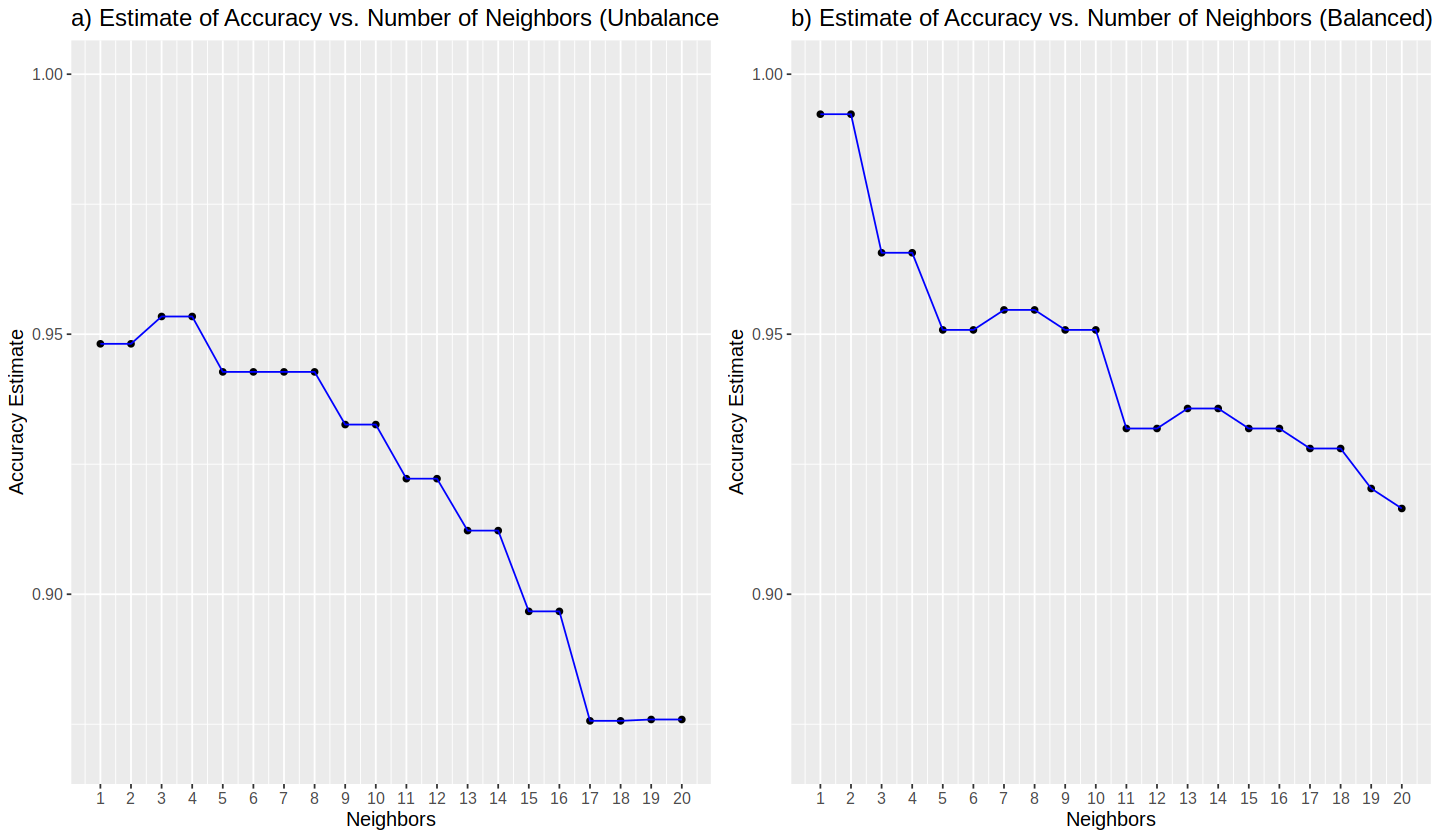

In [24]:
options(repr.plot.width = 12, repr.plot.height = 7)
plot_grid(accuracy_vs_k, accuracy_vs_k_upsampled)

**Figure 4**: Side by side comparison of estimate accuracy vs. number of neighbors for unbalanced (a) and balanced (b) KNN models after tuning the models.

From our two graphs showing the K-value and their accuracies, we can notice a few things. In our unbalanced data, the two K-values with the highest accuracies are K=3 and K=4. For the graph as a whole, the general shape is concave down decreasing. On the other hand, for the balanced data, the two K-values with the highest accuracies are K=1 and K=2, and the general shape of the graph is concave up decreasing.

#### 2.8.6 Choose the appropriate K-value for the training set

Based on Figure 4, we chose K = 3 for both the balanced and unbalanced models. For the unbalanced model, we chose K = 3 because the the accuracy was highest and changed by the smallest amount if we increased or decreased K ([Timbers et al., 2023](https://datasciencebook.ca/)). Furthermore, choosing K = 3 is advantageous over K = 4 because it is less likely to result in a tie since our model has 4 possible classes. We chose K = 3 instead of K = 1 or K = 2 for the balanced model to avoid overfitting ([Timbers et al., 2023](https://datasciencebook.ca/)). 

#### 2.8.7 Create the KNN model using the selected K-value

Tuning the models results in the same number of neighbors, so we only needed to create one final model using K = 3.

In [25]:
know_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")
know_spec_best

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


#### 2.8.8 Train the classifier using the training set

Using our newly created KNN model, we used a workflow to train the both the unbalanced and balanced models with the training set.

In [26]:
# unbalanced
#Create new workflow using the training set
knowledge_best <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(know_spec_best)|>
    fit(knowledge_training)
knowledge_best

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05208333
Best kernel: rectangular
Best k: 3

In [27]:
# balanced
#Create new workflow using the training set
knowledge_best_upsampled <- workflow() |>
    add_recipe(knowledge_recipe_upsampled) |>
    add_model(know_spec_best)|>
    fit(knowledge_upsampled)
knowledge_best_upsampled

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02272727
Best kernel: rectangular
Best k: 3

## 3. Results

### 3.1 Predict the labels for the unseen testing set

After creating the two models (knowledge_best and knowledge_best_upsampled), we proceeded to evaluate our models using the testing set.

In [28]:
# unbalanced
#Predicting the testing set
predict_test <- predict(knowledge_best, knowledge_testing) |>
    bind_cols(knowledge_testing)

accuracy_test <- predict_test |> 
    metrics(truth = user_knowledge, estimate = .pred_class) |>
    filter(.metric == "accuracy")  |>
    mutate("accuracy" = .estimate) |>
    select(accuracy)

In [29]:
# balanced
#Predicting the testing set
predict_test_up <- predict(knowledge_best_upsampled, knowledge_testing) |>
    bind_cols(knowledge_testing)

accuracy_test_up <- predict_test_up |> 
    metrics(truth = user_knowledge, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    mutate("accuracy" = .estimate) |>
    select(accuracy)

In [30]:
# combine both tables to make a final result that just shows the model and the accuracy
accuracies_both_models <- accuracy_test |>
    rbind(accuracy_test_up)
labels <- tibble("model" = c("Unbalanced", "Balanced"))
accuracies_both_models_labelled <- labels |>
     bind_cols(accuracies_both_models)
accuracies_both_models_labelled |>
    mutate(accuracy = accuracy *100)

model,accuracy
<chr>,<dbl>
Unbalanced,96.96970
Balanced,95.45455


**Table 7**: Accuracy (%) of each model (unbalanced and balanced).

The accuracy for the unbalanced model is 97.0% and the accuracy for the balanced (up-sampled) model is 95.5%.

### 3.2 Create confusion matrices for each model

To visualize the accuracy of the testing set, we created two confusion matrices: one for balanced data and one for unbalanced data. Hence, we can compare the values our model predicted with the true values of the testing set.

In [31]:
# unbalanced
confusion_matrix <- predict_test |> 
      conf_mat(truth = user_knowledge, estimate = .pred_class)
confusion_matrix

          Truth
Prediction very_low High Low Middle
  very_low        4    0   1      0
  High            0   16   0      1
  Low             0    0  23      0
  Middle          0    0   0     21

**Table 8**: Confusion Matrix for Testing Set Using Unbalanced Data

The confusion matrix for the unbalanced model (Table 8) shows that two predictions were mislabeled.

In [32]:
# balanced
confusion_matrix_up <- predict_test_up |> 
      conf_mat(truth = user_knowledge, estimate = .pred_class)
confusion_matrix_up

          Truth
Prediction very_low High Low Middle
  very_low        4    0   1      0
  High            0   16   0      1
  Low             0    0  23      1
  Middle          0    0   0     20

**Table 9**: Confusion Matrix for Testing Set Using Balanced Data

The confusion matrix for the balanced model (Table 9) shows that three predictions were mislabeled.

### 3.3 Visualize classification

To visualize our analysis, we created two scatter plots for both the unbalanced (Figure 5) and balanced (Figure 6) models. On the left side, we have an “actual” scatter plot of the actual values of the testing set. On the right side, we have a “predicted” scatter plot of the predicted values our model gave us for the testing set.

In [33]:
# unbalanced
# plot the actual values
knowledge_training_truth <- predict_test |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 11), plot.caption = element_text(hjust = 0)) +
    ggtitle("a) Goal Object Performance vs Pre-Requisite Performance \n Actual Values of User Knowledge (Unbalanced)")

#plot the predicted values
knowledge_training_predicted <- predict_test |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(.pred_class, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 11), plot.caption = element_text(hjust = 0)) +
    ggtitle("b) Goal Object Performance vs Pre-Requisite Performance \n Predicted Values of User Knowledge (Unbalanced)")

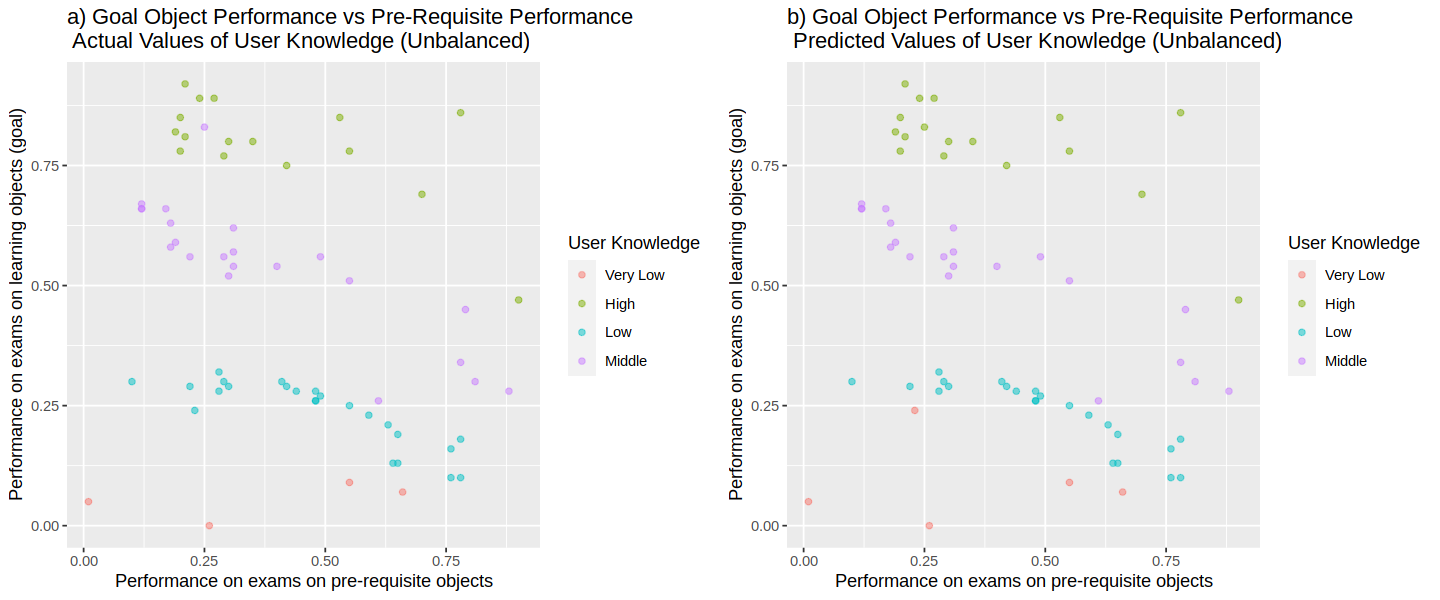

In [34]:
options(repr.plot.width = 12, repr.plot.height = 5)
plot_grid(knowledge_training_truth, knowledge_training_predicted)

**Figure 5**: The classification of user knowledge using unbalanced data of the actual labels (a) and the predicted labels (b).

Figure 5 shows that there are two mislabeled points. One of the points lies around 0.25 on the x-axis (Performance on exams on pre-requisite objects) and 0.25 on the y-axis (Performance on exams on learning objects). This point is labeled as "Low" in the actual values of the testing set, but was predicted as "Very Low" using our model. The other mislabeled point is located around 0.25 on the x-axis (Performance on exams on pre-requisite objects) and 0.8 on the y-axis (Performance on exams on learning objects). This point is labeled as "Middle" in the actual values of the testing set, but was predicted as "High" using our model.


In [35]:
# balanced
# plot the actual values
knowledge_training_truth_up <- predict_test_up |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 11), plot.caption = element_text(hjust = 0)) +
    ggtitle("a) Goal Object Performance vs Pre-Requisite Performance \n Actual Values of User Knowledge (Balanced)")

#plot the predicted values
knowledge_training_predicted_up <- predict_test_up |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(.pred_class, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 11), plot.caption = element_text(hjust = 0)) +
    ggtitle("b) Goal Object Performance vs Pre-Requisite Performance \n Predicted Values of User Knowledge (Balanced)")

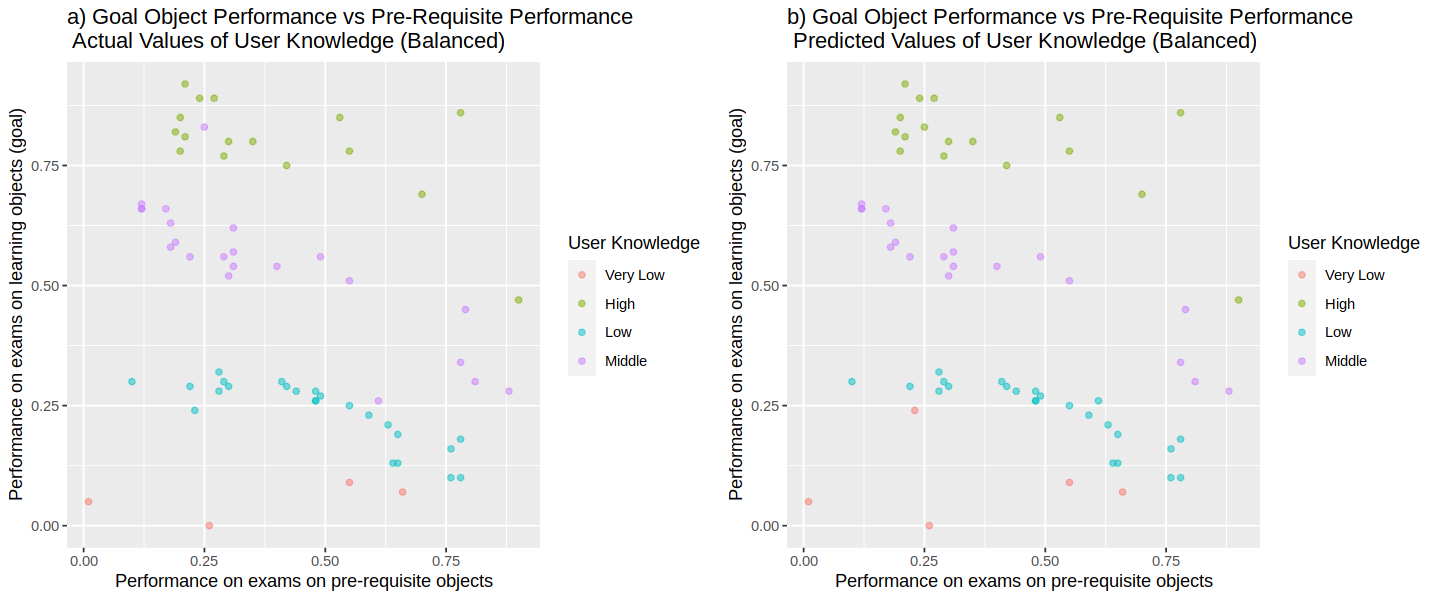

In [36]:
options(repr.plot.width = 12, repr.plot.height = 5)
plot_grid(knowledge_training_truth_up, knowledge_training_predicted_up)

**Figure 6**: The classification of user knowledge using balanced (up-sampled) data of the actual labels (a) and the predicted labels (b).

Figure 6 shows that there are three mislabeled points. One of the points is located around 0.25 on the x-axis (Performance on exams on pre-requisite objects) and 0.25 on the y-axis (Performance on exams on learning objects). This point is labeled as "Low" in the actual values of the testing set, but was predicted as "Very Low" in our model. The second point is located around 0.25 on the x-axis (Performance on exams on pre-requisite objects) and 0.8 on the y-axis (Performance on exams on learning objects). This point is labeled as "Middle" in the actual values of the testing set, but was predicted as "High" using our model. Lastly, the third point is located around 0.6 on the x-axis (Performance on exams on pre-requisite objects) and 0.25 on the y-axis (Performance on exams on learning objects). This point is labeled as "Middle" in the actual values of the testing set, but was predicted as "Low" in our model.

## 4. Discussion

### 4.1 Justification for Two Predictors

Often, having more predictors can bring more harm than good as some of the predictors can hamper the accuracy and recall of classification model later on ([Timbers et al., 2023](https://datasciencebook.ca/)).

In our model, we have chosen to use fewer predictors for this core reason. For example, we did not use “Goal Object Study Time” as a predictor. As seen in Figure 2c  “Goal Object Study Time Vs. Goal Object Performance”, it would hamper our results as it contains weak clusters of “User Knowledge” groups. Thus, it could lead to a lower accuracy in our confusion matrix and more mislabeled values during our data analysis.

In comparison, we use “Pre-Requisite Performance”, as when looking at its respective graph in Figure 2d “Goal Object Performance vs Pre-Requisite Performance", it has strong clusters of “User Knowledge” groups. Thus, this increases the accuracy of our classification model.

Finally, our model having two simple predictors ("Performance on exams on pre-requisite objects” and "Performance on exams on learning objects (goal)") is a good thing. Often in real life, data can go against common-held beliefs or assumptions and thus we must use these predictors to make sure we can re-affirm that our common-beliefs still remain true.


### 4.2 Summary of Results

With our unbalanced KNN-classification model, using our two predictors (prerequisite exam and exam performance), the model produced an accuracy of 97.0% (Table 7). Alongside its high accuracy for prediction, the model's confusion matrix exhibited only two misclassifications (Table 8). In addition, Figure 5 visualized which values were mislabeled, where one value was positioned closely to another cluster (Figure 5a "Middle" mislabeled as "High" when near "High" cluster) and the other was not (Figure 5a "Low" mislabeled as "Very Low" when close to "Low").

As we demonstrated in Figure 1, the data was unbalanced, which could impact the KNN-classification. To account for the unbalance data, we balanced all the user knowledge categories by up-sampling our data. However, when testing our balanced KNN-classification model, it yielded a lower accuracy of 95.5% (Table 7) and three misclassification errors (Table 9). In addition to repeating the same mistakes found in the unbalanced model, the balanced model produced an additional error with a "Middle" misclassified as "Low" when positioned near the "Low" cluster (Figure 6a).

### 4.3 Expectations

We expected the accuracy to be relatively high, which is mostly in line with what we found in our report (unbalanced accuracy 97.0%; balanced accuracy 95.5%). Our hypothesis was that the user's scores on both the prerequisite and goal exam can be used to predict their user knowledge level with high accuracy. As our model yielded very high accuracy, we can accept our hypothesis.

Surprisingly, balancing our data resulted in a model with lower accuracy than unbalanced data. Perhaps using a new set of predictors would solve this issue as using more dimensions would allow further categorization.

### 4.4 Impact of Results

With our results showing that user modeling having high accuracy in predicting the knowledge level of a client, there are many areas we can apply our results to. As our world gets more technologically advanced, there is an increased “importance of moving beyond relevance rankings of search results and considering a user’s knowledge state within learning oriented search settings” ([Yu et al. 2021](https://doi.org/10.1007/s10791-021-09391-7)). This means that for search engines, instead of giving the user the most popular or common answer, we should be instead looking at their knowledge level to provide a curated answer. For example, explaining how a car engine works should differ for a child compared to an adult. 

User modeling opens up opportunities for educational diagnoses, where a machine can store predicted explanations for questions with varying amounts of detail and allow the user to request further. This can lead to personalized interactions in many different fields, such as e-commerce or e-learning. In e-learning, user modeling goes hand-in-hand with student modeling. Since a student’s knowledge is expected to have misconceptions at the start, and change as their learning process proceeds, there is a need for a dynamic system such as user modeling. With it, we would be able to figure out fundamental reasons for student behavior and tailor learning to correct misconceptions or patch holes in their knowledge ([Kass 1989](https://doi.org/10.1007/978-3-642-83230-7_14)). Overall, it is clear that our results regarding the accuracy of user modeling is beneficial to many fields, such as search engines and student modeling. 


### 4.5 Future Questions

Based on our results, we can build upon our model and test the model in a real-world situation. 

**1. What methods can we use to increase the performance of the model? Which additional predictors could we use?**

When comparing the confusion matrices (Table 8 & 9), we found that the "Low" and "Middle" for both the balanced and unbalanced models were misclassified. We used only exam performance on pre-requisite and goal object materials, but we have additional predictors such as degree of repetition of object material and degree of time studied for both object and pre-requisite material. We could approach the problem by creating new models with additional predictors using the forward selection method in R ([Timbers et al., 2023](https://datasciencebook.ca/ )). This method would allow us to test additional predictors and see which are irrelevant and which improve our model.

**2. Can this model be implemented for an online learning environment?**

This study has been shown to have high accuracy for predicting user knowledge levels. In a future study, we could attempt to implement an online learning environment that determines user's knowledge category based on their performance on quizzes in pre-requisite and goal content. We could determine student's satisfaction using this learning model and validate the success of the classifier.

## 5. References

[1](https://doi.org/10.1109/access.2018.2847334) Al-Tarabily, M. M., Abdel-Kader, R. F., Azeem, G. A., & Marie, M. I. (2018). Optimizing Dynamic Multi-Agent Performance in E-Learning Environment, 35631–35645. https://doi.org/10.1109/access.2018.2847334

[2](https://doi.org/10.1016/B978-0-444-70536-5.50051-8) Chignell, M. H., Hancock, P. A., & Helander, M. (1988). Chapter 46 - Intelligent Interface Design. In Handbook of Human-Computer Interaction (pp. 969–995). North Holland. https://doi.org/10.1016/B978-0-444-70536-5.50051-8

[3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2630138/) Hailikari, T., Katajavuori, N., & Lindblom-Ylanne, S. (2008). The Relevance of Prior Knowledge in Learning and Instructional Design. American journal of pharmaceutical education, 72-113. https://doi.org/10.5688/aj7205113

[4](https://doi.org/10.1016/j.knosys.2012.08.009) Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. Knowledge-Based Systems, 37, 283–295. https://doi.org/10.1016/j.knosys.2012.08.009

[5](https://doi.org/10.24432/C5231X) Kahraman, H. T., Sagiroglu, S., & Colak, I.(2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X


[6](https://doi.org/10.1007/978-3-642-83230-7_14) Kass, R. (1989). Student Modeling in Intelligent Tutoring Systems — Implications for  User Modeling. In: Kobsa, A., Wahlster, W. (eds) User Models in Dialog Systems. Symbolic Computation. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-83230-7_14


[7](https://datasciencebook.ca/ ) Timbers, T., Campbell, T., & Lee, M. (2023) Data Science: A First Introduction. CRC Press, Taylor & Francis Group. https://datasciencebook.ca/ 

[8](https://doi.org/10.1007/s10791-021-09391-7) Yu, R., Tang, R., Rokicki, M. et al. (2021). Topic-independent modeling of user  knowledge in informational search sessions. Information Retrieval Journal 24, 240–268. https://doi.org/10.1007/s10791-021-09391-7
